In [29]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [30]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, det_curve, auc
import json
import os
import pandas as pd

# Lista para armazenar resultados
results_table = []

def process_file(file_path, train_dataset, test_dataset, split):
    with open(file_path, 'r') as f:
        lines = f.readlines()

    scores, labels = [], []
    for line in lines:
        parts = line.strip().split(',')
        scores.append(float(parts[1]))
        labels.append(float(parts[2]))
    scores = np.array(scores)
    labels = np.array(labels)

    # ROC and AUC
    fpr, tpr, thresholds = roc_curve(labels, scores)
    roc_auc = auc(fpr, tpr)

    # DET curve and D-EER
    det_fpr, det_fnr, _ = det_curve(labels, scores)
    eer_idx = np.nanargmin(np.abs(det_fpr - det_fnr))
    d_eer = (det_fpr[eer_idx] + det_fnr[eer_idx]) / 2

    # APCER/BPCER helpers
    def apcer_at_bpcer(x):
        idx = next((i for i, b in enumerate(1 - tpr) if b <= x), None)
        return fpr[idx] if idx is not None else None

    def bpcer_at_apcer(x):
        idx = next((i for i, a in enumerate(fpr) if a <= x), None)
        return (1 - tpr[idx]) if idx is not None else None

    thresholds = [0.01, 0.05, 0.10]
    apcer_values = [apcer_at_bpcer(t) for t in thresholds]
    bpcer_values = [bpcer_at_apcer(t) for t in thresholds]

    # Adiciona resultado à tabela
    results_table.append({
        'Train Dataset': train_dataset,
        'Trained with data': split,
        'Test Dataset': test_dataset,
        'D-EER (%)': round(d_eer * 100, 2),
        'AUC (%)': round(roc_auc * 100, 2),
        'APCER@BPCER=1%': round(apcer_values[0] * 100, 2) if apcer_values[0] is not None else None,
        'BPCER@APCER=1%': round(bpcer_values[0] * 100, 2) if bpcer_values[0] is not None else None,
        'APCER@BPCER=5%': round(apcer_values[1] * 100, 2) if apcer_values[1] is not None else None,
        'BPCER@APCER=5%': round(bpcer_values[1] * 100, 2) if bpcer_values[1] is not None else None,
        'APCER@BPCER=10%': round(apcer_values[2] * 100, 2) if apcer_values[2] is not None else None,
        'BPCER@APCER=10%': round(bpcer_values[2] * 100, 2) if bpcer_values[2] is not None else None,
    })

    # Opcional: mostrar os gráficos
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, label=f'ROC (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('FAR (APCER)')
    plt.ylabel('TAR (1 - BPCER)')
    plt.title(f'ROC Curve\n{os.path.basename(file_path)}')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(det_fpr, det_fnr, label=f'DET (D-EER = {d_eer:.4f})')
    plt.xlabel('FAR (APCER)')
    plt.ylabel('FRR (BPCER)')
    plt.title(f'DET Curve\n{os.path.basename(file_path)}')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Carrega config
with open('/content/drive/MyDrive/mad/code/ViT-SVM/configs/dataset_configs.json', 'r') as f:
    dataset_configs = json.load(f)

# Percorre diretórios e processa ficheiros
for train_key in dataset_configs:
    results_path = dataset_configs[train_key].get('results_path', None)
    if results_path is None:
        continue

    try:
        model_subdirs = [d for d in os.listdir(results_path) if os.path.isdir(os.path.join(results_path, d))]
    except FileNotFoundError:
        continue

    for model_subdir in model_subdirs:
        model_results_dir = os.path.join(results_path, model_subdir)
        unbalanced_path = os.path.join(model_results_dir, 'test_using_train_model_with_unbalanced_data.txt')
        balanced_path = os.path.join(model_results_dir, 'test_using_train_model_with_balanced_data.txt')

        if os.path.exists(unbalanced_path):
            process_file(unbalanced_path, train_key, model_subdir, 'Unbalanced')

        if os.path.exists(balanced_path):
            process_file(balanced_path, train_key, model_subdir, 'Balanced')

# Cria tabela com pandas
df = pd.DataFrame(results_table)

# Reorganizar colunas: "Trained with data" primeiro
cols = df.columns.tolist()
cols.insert(0, cols.pop(cols.index("Trained with data")))
df = df[cols]

df["Trained_Sort"] = df["Trained with data"].apply(lambda x: 0 if x == "Unbalanced" else 1)
df["Train_Sort"] = df["Train Dataset"].apply(lambda x: 0 if "-cropped" not in x else 1)
df["Test_Sort"] = df["Test Dataset"].apply(lambda x: 0 if "-cropped" not in x else 1)

# Sort using the helper columns
df_sorted = df.sort_values(by=["Trained_Sort", "Train_Sort", "Test_Sort"]).drop(columns=["Trained_Sort", "Train_Sort", "Test_Sort"])

print("\n=== Final results table ===\n")
print(df_sorted.to_string(index=False))

# Salvar como CSV (opcional)
df_sorted.to_csv("/content/drive/MyDrive/mad/code/ViT-SVM/mad_scores/results_table.csv", index=False)


Output hidden; open in https://colab.research.google.com to view.

Saved ROC graph: /content/drive/MyDrive/mad/code/ViT-SVM/analysis_graphs/ROC_curves_frll_Balanced.png
Saved DET graph: /content/drive/MyDrive/mad/code/ViT-SVM/analysis_graphs/DET_curves_frll_Balanced.png


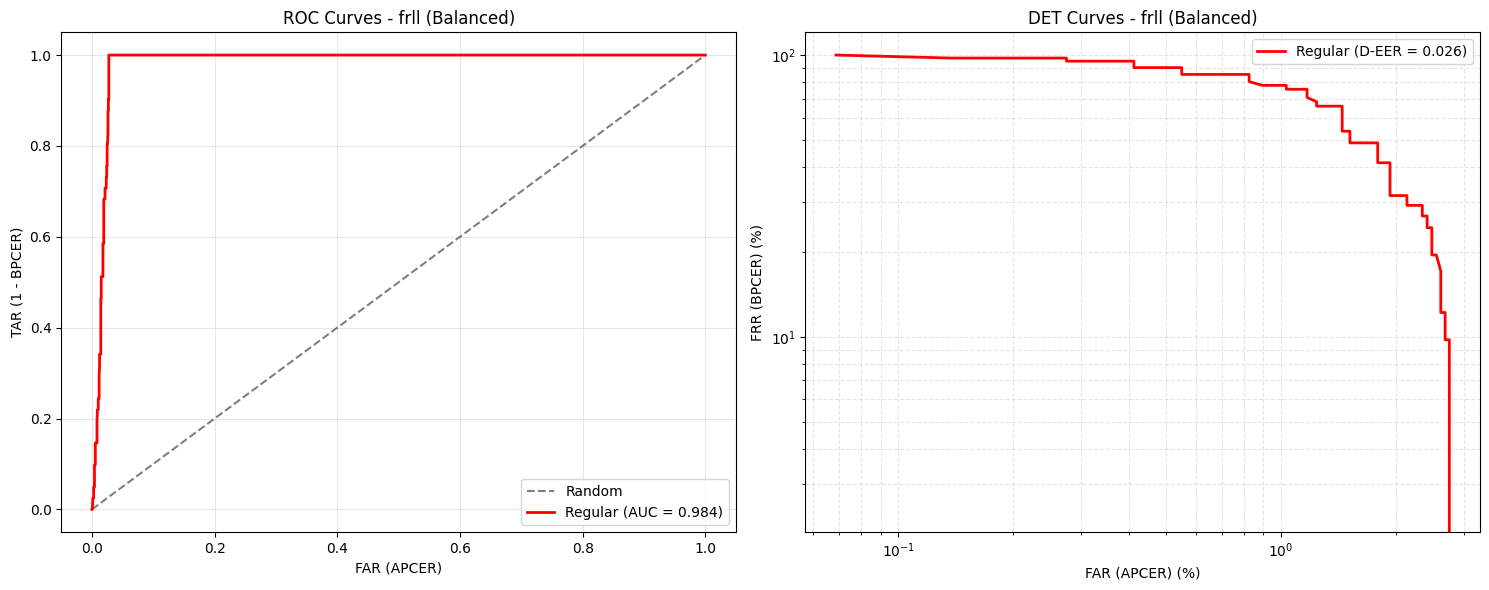

Saved ROC graph: /content/drive/MyDrive/mad/code/ViT-SVM/analysis_graphs/ROC_curves_frll_Unbalanced.png
Saved DET graph: /content/drive/MyDrive/mad/code/ViT-SVM/analysis_graphs/DET_curves_frll_Unbalanced.png


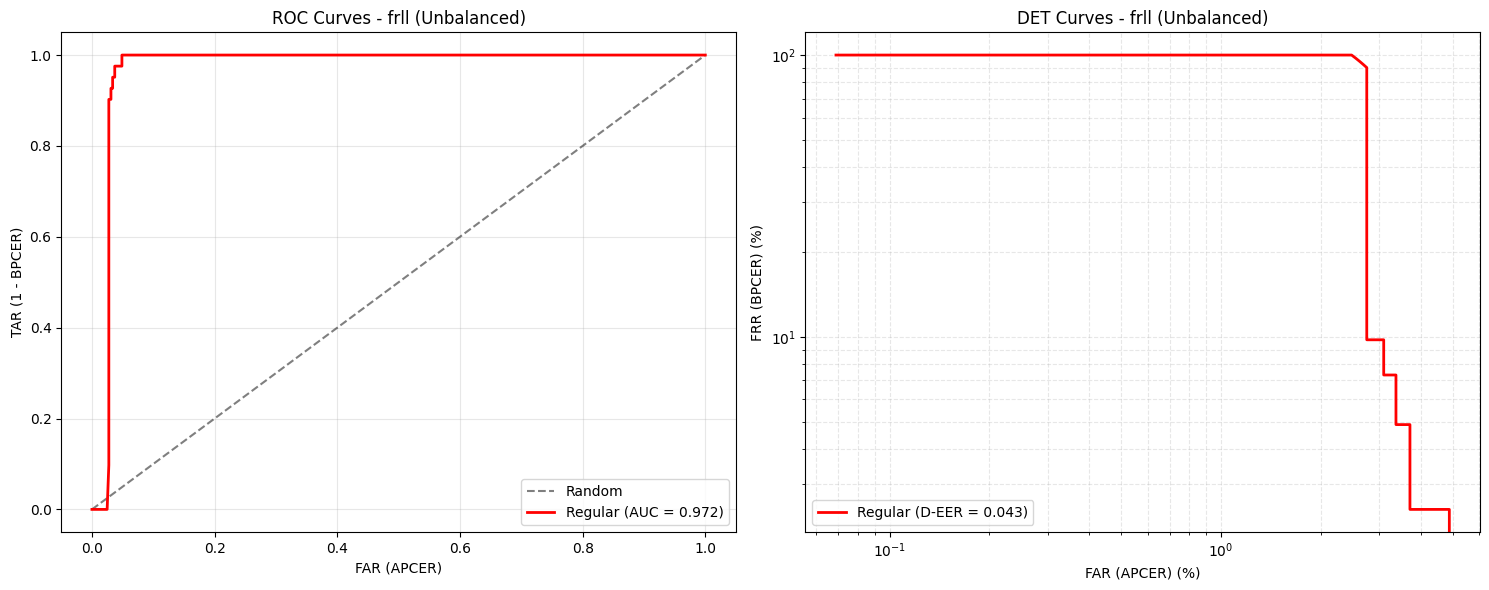

Saved ROC graph: /content/drive/MyDrive/mad/code/ViT-SVM/analysis_graphs/ROC_curves_frll-cropped_Balanced.png
Saved DET graph: /content/drive/MyDrive/mad/code/ViT-SVM/analysis_graphs/DET_curves_frll-cropped_Balanced.png


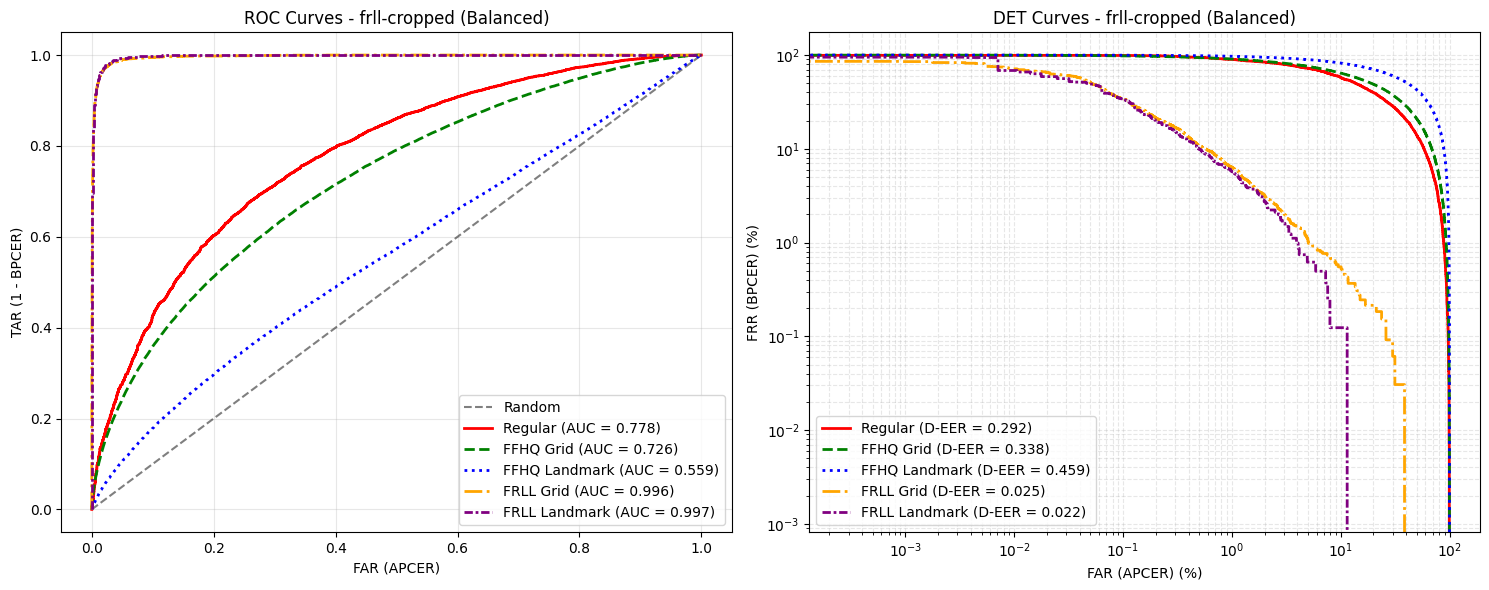

Saved ROC graph: /content/drive/MyDrive/mad/code/ViT-SVM/analysis_graphs/ROC_curves_frll-cropped_Unbalanced.png
Saved DET graph: /content/drive/MyDrive/mad/code/ViT-SVM/analysis_graphs/DET_curves_frll-cropped_Unbalanced.png


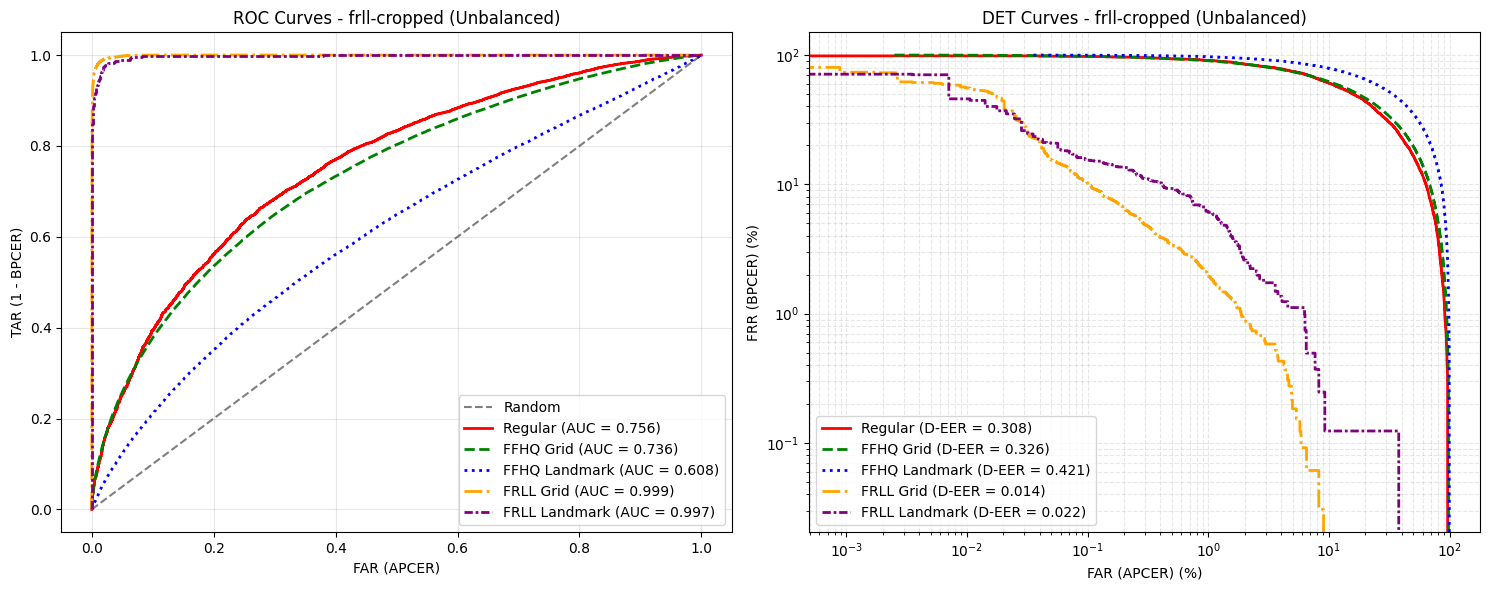

Saved ROC graph: /content/drive/MyDrive/mad/code/ViT-SVM/analysis_graphs/ROC_curves_ffhq-cropped_Balanced.png
Saved DET graph: /content/drive/MyDrive/mad/code/ViT-SVM/analysis_graphs/DET_curves_ffhq-cropped_Balanced.png


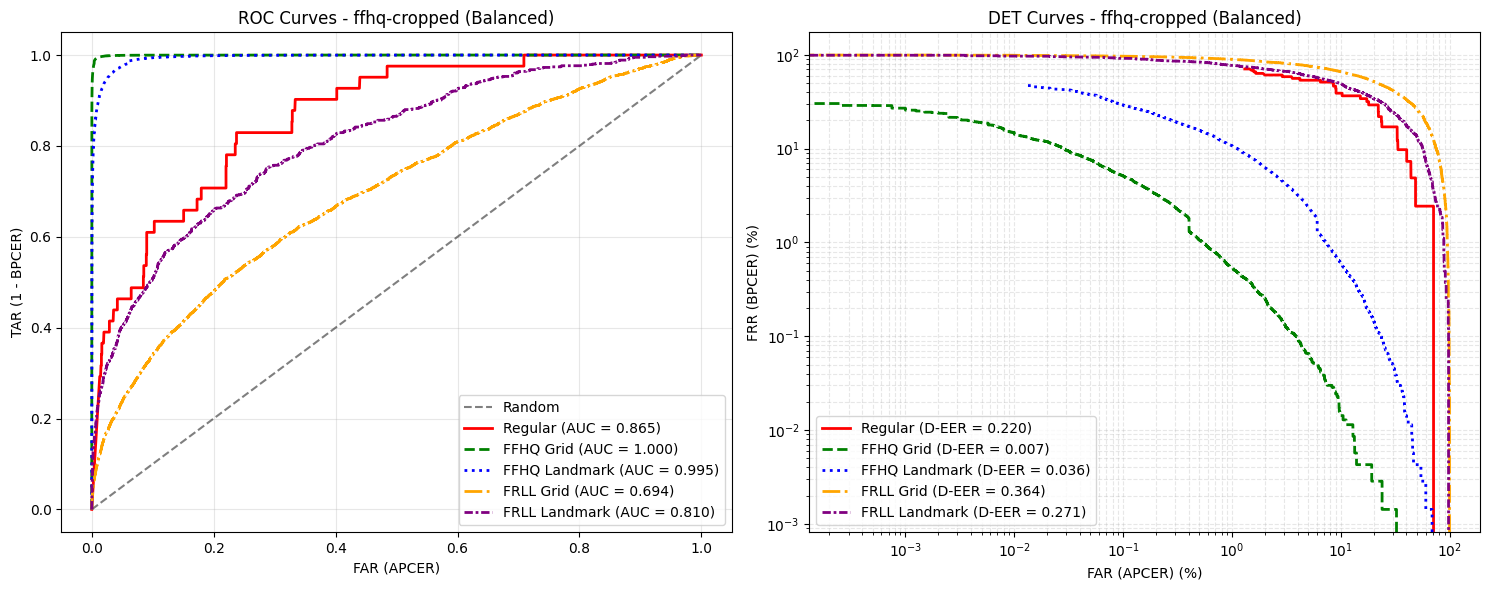

Saved ROC graph: /content/drive/MyDrive/mad/code/ViT-SVM/analysis_graphs/ROC_curves_ffhq-cropped_Unbalanced.png
Saved DET graph: /content/drive/MyDrive/mad/code/ViT-SVM/analysis_graphs/DET_curves_ffhq-cropped_Unbalanced.png


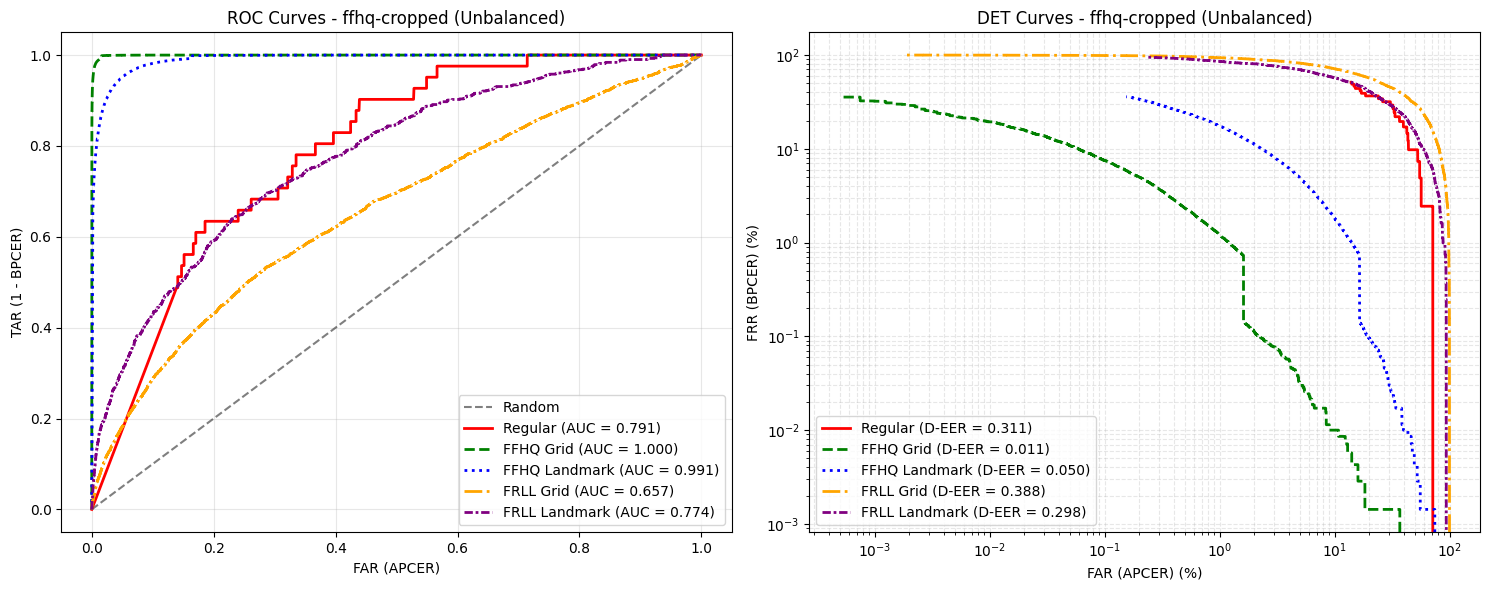

Saved ROC graph: /content/drive/MyDrive/mad/code/ViT-SVM/analysis_graphs/ROC_curves_ffhq_Balanced.png
Saved DET graph: /content/drive/MyDrive/mad/code/ViT-SVM/analysis_graphs/DET_curves_ffhq_Balanced.png


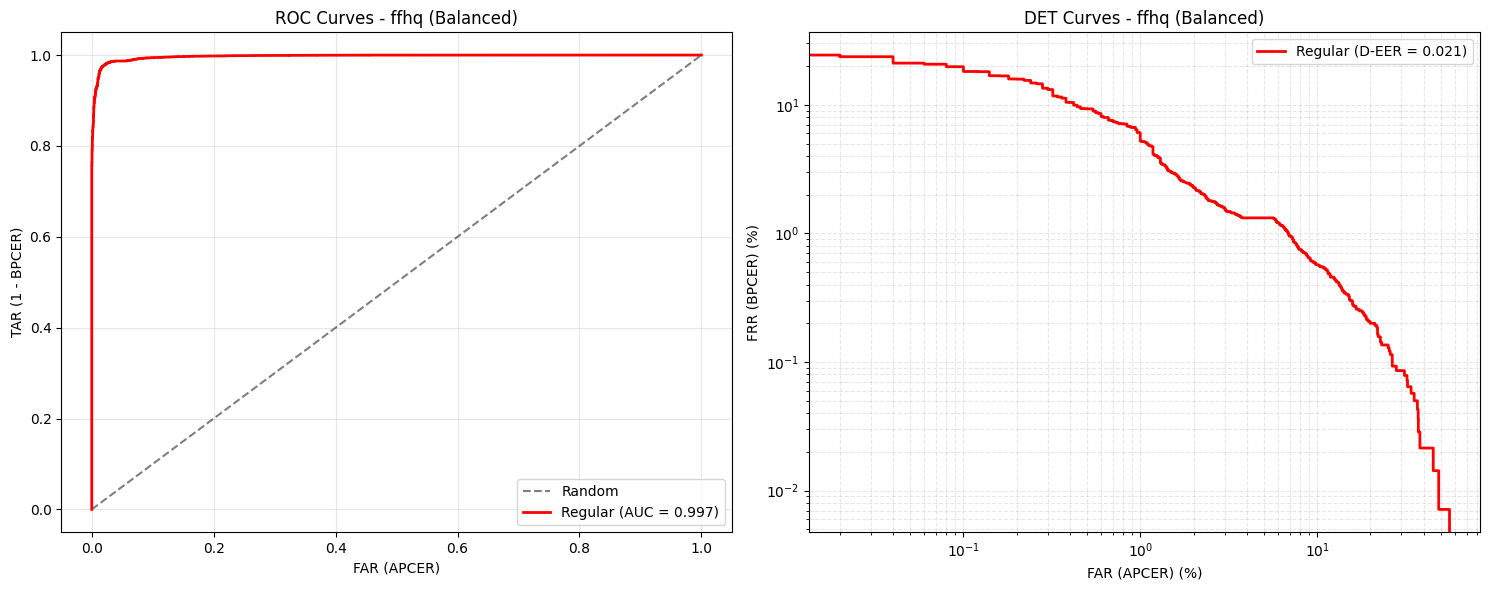

Saved ROC graph: /content/drive/MyDrive/mad/code/ViT-SVM/analysis_graphs/ROC_curves_ffhq_Unbalanced.png
Saved DET graph: /content/drive/MyDrive/mad/code/ViT-SVM/analysis_graphs/DET_curves_ffhq_Unbalanced.png


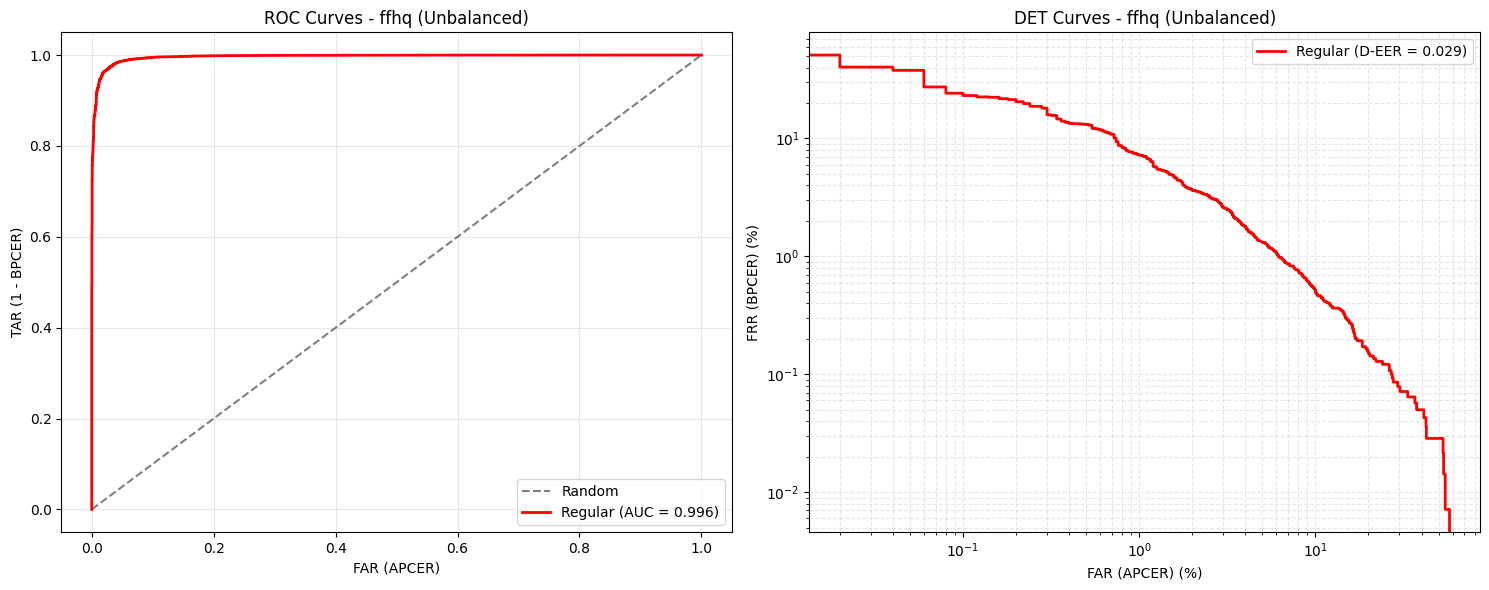


All graphs have been saved to: /content/drive/MyDrive/mad/code/ViT-SVM/analysis_graphs/

=== Final results table ===

Trained with data Train Dataset                    Test Dataset  D-EER (%)  AUC (%)  APCER@BPCER=1%  BPCER@APCER=1%  APCER@BPCER=5%  BPCER@APCER=5%  APCER@BPCER=10%  BPCER@APCER=10%
       Unbalanced          ffhq                            frll      39.02    65.72           97.59           100.0           83.76           100.0            77.70            100.0
       Unbalanced          ffhq                            ffhq       2.85    99.63            6.22           100.0            1.48           100.0             0.74            100.0
       Unbalanced          frll                            ffhq      46.53    55.00           98.96           100.0           94.02           100.0            87.99            100.0
       Unbalanced          frll                            frll       4.30    97.16            4.89           100.0            3.37           100.0      

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, det_curve, auc
import json
import os

# Define colors and line styles for different occlusion types
colors = ["red", "green", "blue", "orange", "purple", "cyan", "magenta", "brown"]
line_styles = {
    'regular': '-',
    'ffhq-grid': '--',
    'ffhq-landmark': ':',
    'frll-grid': '-.',
    'frll-landmark': (0, (3, 1, 1, 1))  # dash-dot-dot pattern
}

# Function to determine occlusion type from test dataset name
def get_occlusion_type(test_dataset_name):
    if 'ffhq-grid-occlusion' in test_dataset_name.lower():
        return 'ffhq-grid'
    elif 'ffhq-landmark-occlusion' in test_dataset_name.lower():
        return 'ffhq-landmark'
    elif 'frll-grid-occlusion' in test_dataset_name.lower():
        return 'frll-grid'
    elif 'frll-landmark-occlusion' in test_dataset_name.lower():
        return 'frll-landmark'
    else:
        return 'regular'

# Dictionary to store all data for plotting
plot_data = {}

# Lista para armazenar resultados
results_table = []

def process_file(file_path, train_dataset, test_dataset, split):
    with open(file_path, 'r') as f:
        lines = f.readlines()

    scores, labels = [], []
    for line in lines:
        parts = line.strip().split(',')
        scores.append(float(parts[1]))
        labels.append(float(parts[2]))
    scores = np.array(scores)
    labels = np.array(labels)

    # ROC and AUC
    fpr, tpr, thresholds = roc_curve(labels, scores)
    roc_auc = auc(fpr, tpr)

    # DET curve and D-EER
    det_fpr, det_fnr, _ = det_curve(labels, scores)
    eer_idx = np.nanargmin(np.abs(det_fpr - det_fnr))
    d_eer = (det_fpr[eer_idx] + det_fnr[eer_idx]) / 2

    # Store data for plotting
    occlusion_type = get_occlusion_type(test_dataset)
    key = (train_dataset, split)
    if key not in plot_data:
        plot_data[key] = {}
    plot_data[key][occlusion_type] = {
        'fpr': fpr,
        'tpr': tpr,
        'det_fpr': det_fpr,
        'det_fnr': det_fnr,
        'scores': scores,
        'labels': labels,
        'auc': roc_auc,
        'd_eer': d_eer
    }

    # APCER/BPCER helpers
    def apcer_at_bpcer(x):
        idx = next((i for i, b in enumerate(1 - tpr) if b <= x), None)
        return fpr[idx] if idx is not None else None

    def bpcer_at_apcer(x):
        idx = next((i for i, a in enumerate(fpr) if a <= x), None)
        return (1 - tpr[idx]) if idx is not None else None

    thresholds_vals = [0.01, 0.05, 0.10]
    apcer_values = [apcer_at_bpcer(t) for t in thresholds_vals]
    bpcer_values = [bpcer_at_apcer(t) for t in thresholds_vals]

    # Adiciona resultado à tabela
    results_table.append({
        'Train Dataset': train_dataset,
        'Trained with data': split,
        'Test Dataset': test_dataset,
        'D-EER (%)': round(d_eer * 100, 2),
        'AUC (%)': round(roc_auc * 100, 2),
        'APCER@BPCER=1%': round(apcer_values[0] * 100, 2) if apcer_values[0] is not None else None,
        'BPCER@APCER=1%': round(bpcer_values[0] * 100, 2) if bpcer_values[0] is not None else None,
        'APCER@BPCER=5%': round(apcer_values[1] * 100, 2) if apcer_values[1] is not None else None,
        'BPCER@APCER=5%': round(bpcer_values[1] * 100, 2) if bpcer_values[1] is not None else None,
        'APCER@BPCER=10%': round(apcer_values[2] * 100, 2) if apcer_values[2] is not None else None,
        'BPCER@APCER=10%': round(bpcer_values[2] * 100, 2) if bpcer_values[2] is not None else None,
    })

def plot_combined_curves():
    """Plot ROC and DET curves for each model with regular, grid, and landmark results"""

    # Create output directory for graphs
    output_dir = "/content/drive/MyDrive/mad/code/ViT-SVM/analysis_graphs/"
    os.makedirs(output_dir, exist_ok=True)

    # Get unique models
    models = set([key[0] for key in plot_data.keys()])

    for model in models:
        # Create separate plots for balanced and unbalanced
        for split in ['Balanced', 'Unbalanced']:
            key = (model, split)
            if key not in plot_data:
                continue

            # Create combined figure for display (side by side)
            fig_combined, (ax_roc_display, ax_det_display) = plt.subplots(1, 2, figsize=(15, 6))
            ax_roc_display.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random')
            ax_det_display.set_xscale('log')
            ax_det_display.set_yscale('log')
            ax_det_display.grid(True, which="both", linestyle='--', alpha=0.3)

            # Create separate ROC figure for saving (don't show)
            fig_roc = plt.figure(figsize=(10, 8))
            ax_roc = fig_roc.add_subplot(111)
            ax_roc.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random')

            # Create separate DET figure for saving (don't show)
            fig_det = plt.figure(figsize=(10, 8))
            ax_det = fig_det.add_subplot(111)
            ax_det.set_xscale('log')
            ax_det.set_yscale('log')
            ax_det.grid(True, which="both", linestyle='--', alpha=0.3)

            occlusion_types = ['regular', 'ffhq-grid', 'ffhq-landmark', 'frll-grid', 'frll-landmark']
            color_idx = 0

            for occlusion_type in occlusion_types:
                if occlusion_type in plot_data[key]:
                    data = plot_data[key][occlusion_type]
                    color = colors[color_idx % len(colors)]
                    linestyle = line_styles[occlusion_type]

                    # Create readable label
                    if occlusion_type == 'regular':
                        label_name = 'Regular'
                    elif occlusion_type == 'ffhq-grid':
                        label_name = 'FFHQ Grid'
                    elif occlusion_type == 'ffhq-landmark':
                        label_name = 'FFHQ Landmark'
                    elif occlusion_type == 'frll-grid':
                        label_name = 'FRLL Grid'
                    elif occlusion_type == 'frll-landmark':
                        label_name = 'FRLL Landmark'

                    # ROC curves (both display and save versions)
                    ax_roc_display.plot(data['fpr'], data['tpr'],
                            color=color, linestyle=linestyle, linewidth=2,
                            label=f'{label_name} (AUC = {data["auc"]:.3f})')
                    ax_roc.plot(data['fpr'], data['tpr'],
                            color=color, linestyle=linestyle, linewidth=2,
                            label=f'{label_name} (AUC = {data["auc"]:.3f})')

                    # DET curves (both display and save versions)
                    ax_det_display.plot(data['det_fpr'] * 100, data['det_fnr'] * 100,
                            color=color, linestyle=linestyle, linewidth=2,
                            label=f'{label_name} (D-EER = {data["d_eer"]:.3f})')
                    ax_det.plot(data['det_fpr'] * 100, data['det_fnr'] * 100,
                            color=color, linestyle=linestyle, linewidth=2,
                            label=f'{label_name} (D-EER = {data["d_eer"]:.3f})')

                    color_idx += 1

            # Configure display plots (side by side)
            ax_roc_display.set_xlabel('FAR (APCER)')
            ax_roc_display.set_ylabel('TAR (1 - BPCER)')
            ax_roc_display.set_title(f'ROC Curves - {model} ({split})')
            ax_roc_display.legend()
            ax_roc_display.grid(True, alpha=0.3)

            ax_det_display.set_xlabel('FAR (APCER) (%)')
            ax_det_display.set_ylabel('FRR (BPCER) (%)')
            ax_det_display.set_title(f'DET Curves - {model} ({split})')
            ax_det_display.legend()

            # Configure individual ROC plot for saving
            ax_roc.set_xlabel('FAR (APCER)')
            ax_roc.set_ylabel('TAR (1 - BPCER)')
            ax_roc.set_title(f'ROC Curves - {model} ({split})')
            ax_roc.legend()
            ax_roc.grid(True, alpha=0.3)

            # Configure individual DET plot for saving
            ax_det.set_xlabel('FAR (APCER) (%)')
            ax_det.set_ylabel('FRR (BPCER) (%)')
            ax_det.set_title(f'DET Curves - {model} ({split})')
            ax_det.legend()

            # Clean model name for filename (remove special characters)
            clean_model_name = "".join(c for c in model if c.isalnum() or c in (' ', '-', '_')).rstrip()
            clean_model_name = clean_model_name.replace(' ', '_')

            # Save individual ROC figure (without showing)
            fig_roc.tight_layout()
            roc_filename = f"ROC_curves_{clean_model_name}_{split}.png"
            roc_filepath = os.path.join(output_dir, roc_filename)
            fig_roc.savefig(roc_filepath, dpi=300, bbox_inches='tight', facecolor='white')
            print(f"Saved ROC graph: {roc_filepath}")

            # Save individual DET figure (without showing)
            fig_det.tight_layout()
            det_filename = f"DET_curves_{clean_model_name}_{split}.png"
            det_filepath = os.path.join(output_dir, det_filename)
            fig_det.savefig(det_filepath, dpi=300, bbox_inches='tight', facecolor='white')
            print(f"Saved DET graph: {det_filepath}")

            # Close individual figures immediately (don't show them)
            plt.close(fig_roc)
            plt.close(fig_det)

            # Show only the combined side-by-side display
            fig_combined.tight_layout()
            plt.show()

            # Close combined figure after showing
            plt.close(fig_combined)

    print(f"\nAll graphs have been saved to: {output_dir}")

# Load config and process files
def main():
    # Load regular dataset configs
    with open('/content/drive/MyDrive/mad/code/ViT-SVM/configs/dataset_configs.json', 'r') as f:
        dataset_configs = json.load(f)

    # Load occlusion dataset configs
    with open('/content/drive/MyDrive/mad/code/ViT-SVM/configs/occlusion_dataset_configs.json', 'r') as f:
        occlusion_configs = json.load(f)

    # Process regular (non-occluded) results
    for train_key in dataset_configs:
        results_path = dataset_configs[train_key].get('results_path', None)
        if results_path is None:
            continue

        try:
            model_subdirs = [d for d in os.listdir(results_path) if os.path.isdir(os.path.join(results_path, d))]
        except FileNotFoundError:
            continue

        for model_subdir in model_subdirs:
            model_results_dir = os.path.join(results_path, model_subdir)

            # Process regular test files
            test_files = [
                ('test_using_train_model_with_unbalanced_data.txt', 'Unbalanced'),
                ('test_using_train_model_with_balanced_data.txt', 'Balanced'),
            ]

            for test_file, split_type in test_files:
                test_path = os.path.join(model_results_dir, test_file)
                if os.path.exists(test_path):
                    # Use model_subdir as test dataset name for regular tests
                    process_file(test_path, train_key, model_subdir, split_type)

    # Process occlusion results (grid and landmark)
    for occlusion_key in occlusion_configs:
        results_path = occlusion_configs[occlusion_key].get('results_path', None)
        if results_path is None:
            continue

        try:
            model_subdirs = [d for d in os.listdir(results_path) if os.path.isdir(os.path.join(results_path, d))]
        except FileNotFoundError:
            continue

        for model_subdir in model_subdirs:
            model_results_dir = os.path.join(results_path, model_subdir)

            # Process occlusion test files
            test_files = [
                ('test_using_train_model_with_unbalanced_data.txt', 'Unbalanced'),
                ('test_using_train_model_with_balanced_data.txt', 'Balanced'),
            ]

            for test_file, split_type in test_files:
                test_path = os.path.join(model_results_dir, test_file)
                if os.path.exists(test_path):
                    # Use occlusion_key as test dataset name for occlusion tests
                    process_file(test_path, model_subdir, occlusion_key, split_type)

    # Plot the combined curves
    plot_combined_curves()

    # Create results table
    df = pd.DataFrame(results_table)

    # Reorganizar colunas: "Trained with data" primeiro
    cols = df.columns.tolist()
    cols.insert(0, cols.pop(cols.index("Trained with data")))
    df = df[cols]

    df["Trained_Sort"] = df["Trained with data"].apply(lambda x: 0 if x == "Unbalanced" else 1)
    df["Train_Sort"] = df["Train Dataset"].apply(lambda x: 0 if "-cropped" not in x else 1)
    df["Test_Sort"] = df["Test Dataset"].apply(lambda x: 0 if "-cropped" not in x else 1)

    # Sort using the helper columns
    df_sorted = df.sort_values(by=["Trained_Sort", "Train_Sort", "Test_Sort"]).drop(columns=["Trained_Sort", "Train_Sort", "Test_Sort"])

    print("\n=== Final results table ===\n")
    print(df_sorted.to_string(index=False))

    # Salvar como CSV (opcional)
    df_sorted.to_csv("/content/drive/MyDrive/mad/code/ViT-SVM/mad_scores/results_table.csv", index=False)

if __name__ == "__main__":
    main()


In [32]:
import json
import os
import random
import glob
import re

# === Configuration ===
num_images_to_visualize = 25
grid_rows, grid_cols = 4, 4
landmarks = ['left_eye', 'right_eye', 'nose', 'mouth']

# Change results obtained
model_test_key = 'frll' # ffhq or frll
occlusion_test_key = 'ffhq' # ffhq or frll


# === Load Configuration Files ===
model_key = f'{model_test_key}-cropped'
regular_test_key = f'{occlusion_test_key}-cropped'
occlusion_results_folder = f'{occlusion_test_key}-occlusion-mapping'
grid_test_key = f'{occlusion_test_key}-grid-occlusion-mapping'
landmark_test_key = f'{occlusion_test_key}-landmark-occlusion-mapping'

# Load regular dataset configs
with open('/content/drive/MyDrive/mad/code/ViT-SVM/configs/dataset_configs.json', 'r') as f:
    dataset_configs = json.load(f)

# Load occlusion dataset configs
with open('/content/drive/MyDrive/mad/code/ViT-SVM/configs/occlusion_dataset_configs.json', 'r') as f:
    occlusion_dataset_configs = json.load(f)

# === Extract Dataset Configurations ===
# Paths for regular dataset
regular_config_dataset = dataset_configs.get(regular_test_key, {})
regular_images_path = regular_config_dataset.get('morph_images_path', '')
regular_bonafide_path = regular_config_dataset.get('bonafide_images_path', '')

# Paths for grid occlusion dataset
grid_config = occlusion_dataset_configs.get(grid_test_key, {})
grid_images_path = grid_config.get('morph_images_path', '')
grid_bonafide_path = grid_config.get('bonafide_images_path', '')

# Paths for landmark occlusion dataset
landmark_config = occlusion_dataset_configs.get(landmark_test_key, {})
landmark_images_path = landmark_config.get('morph_images_path', '')
landmark_bonafide_path = landmark_config.get('bonafide_images_path', '')

# === Helper Function to Get Image Paths ===
def get_image_paths(dataset_configs, dataset_key):
    """
    Scans the morph and bonafide image directories for a given dataset
    and returns a dictionary mapping relative paths to absolute paths.
    """
    image_paths = {}
    if dataset_key not in dataset_configs:
        return image_paths

    config = dataset_configs[dataset_key]

    # Scan both morph and bonafide directories
    for path_key in ['morph_images_path', 'bonafide_images_path']:
        image_dir = config.get(path_key)
        if image_dir and os.path.exists(image_dir):
            # Walk through all subdirectories
            for root, _, files in os.walk(image_dir):
                for file in files:
                    # Create relative path from the base image directory
                    rel_path = os.path.relpath(os.path.join(root, file), image_dir)
                    # Store mapping from relative path to absolute path
                    image_paths[rel_path] = os.path.join(root, file)

    return image_paths

def get_last_two_parts(path):
    """
    Get the last 2 parts of a path.
    Example: /a/b/c/d -> c/d
    """
    parts = path.split(os.sep)
    if len(parts) >= 2:
        return os.path.join(parts[-2], parts[-1])
    else:
        return path

def has_complete_occlusion_set(image_key, grid_paths, landmark_paths):
    """
    Check if an image has a complete set of grid cell and landmark occlusions
    """
    image_basename = get_last_two_parts(image_key)

    # Check grid occlusions
    grid_matches = [k for k in grid_paths.keys() if image_basename in k]
    grid_cells = set()

    for match in grid_matches:
        # Extract cell coordinates from filename (assuming format like "cell_r{row}_c{col}")
        cell_match = re.search(r'r(\d+)_c(\d+)', match)
        if cell_match:
            row, col = int(cell_match.group(1)), int(cell_match.group(2))
            grid_cells.add((row, col))

    # Check if we have all grid cells
    all_grid_cells = set((r, c) for r in range(grid_rows) for c in range(grid_cols))
    has_all_grid_cells = grid_cells == all_grid_cells

    # Check landmark occlusions
    landmark_matches = [k for k in landmark_paths.keys() if image_basename in k]
    found_landmarks = set()

    for match in landmark_matches:
        for landmark in landmarks:
            if f"{landmark}" in match:
                found_landmarks.add(landmark)

    has_all_landmarks = found_landmarks == set(landmarks)

    return has_all_grid_cells and has_all_landmarks, grid_matches, landmark_matches

# === Get Image Paths from All Configurations ===
print("Loading image paths from datasets...")

# Get image paths from regular dataset
all_image_paths = get_image_paths(dataset_configs, regular_test_key)
print(f"Found {len(all_image_paths)} images in regular dataset ({regular_test_key})")

# Get image paths from grid occlusion dataset
grid_image_paths = get_image_paths(occlusion_dataset_configs, grid_test_key)
print(f"Found {len(grid_image_paths)} images in grid occlusion dataset ({grid_test_key})")

# Get image paths from landmark occlusion dataset
landmark_image_paths = get_image_paths(occlusion_dataset_configs, landmark_test_key)
print(f"Found {len(landmark_image_paths)} images in landmark occlusion dataset ({landmark_test_key})")

# === Load Test Results to Filter Available Images ===
print("\nLoading test results to identify images with available test data...")

# Get configuration details for loading test results
regular_config = dataset_configs.get(model_key)
if not regular_config:
    print(f"Error: Could not find configuration for {model_key}")
    raise ValueError(f"Configuration not found for {model_key}")

regular_results_path = regular_config['results_path']
regular_model_dir = os.path.join(regular_results_path, regular_test_key)
regular_test_file = os.path.join(regular_model_dir, 'test_using_train_model_with_balanced_data.txt')

# Load test results to get available image keys
available_test_image_keys = set()
if os.path.exists(regular_test_file):
    with open(regular_test_file, 'r') as f:
        for line in f:
            parts = line.strip().split(',')
            if len(parts) >= 3:
                image_key = parts[0]
                available_test_image_keys.add(image_key)
    print(f"Found {len(available_test_image_keys)} images with test results")
else:
    print(f"Warning: Test results file not found: {regular_test_file}")

# Filter image keys to only include those with test results
image_keys_with_results = [key for key, value in all_image_paths.items() if value in available_test_image_keys]
print(f"Filtered to {len(image_keys_with_results)} images that have both complete occlusion sets and test results")

# === Find Images with Complete Occlusion Sets ===
print("\nSearching for images with complete occlusion sets...")

# Shuffle the filtered image keys to randomize the search
random.shuffle(image_keys_with_results)

# Find the first num_images_to_visualize complete sets
complete_image_keys = []
checked_count = 0

for image_key in image_keys_with_results:
    checked_count += 1
    is_complete, grid_matches, landmark_matches = has_complete_occlusion_set(
        image_key, grid_image_paths, landmark_image_paths
    )

    if is_complete:
        complete_image_key = all_image_paths.get(image_key)
        complete_grid_matches = [ grid_image_paths.get(grid_image_key) for grid_image_key in grid_matches]
        complete_landmark_matches = [ landmark_image_paths.get(landmark_image_key) for landmark_image_key in landmark_matches]

        complete_image_keys.append((complete_image_key, complete_grid_matches, complete_landmark_matches))
        print(f"Found complete set {len(complete_image_keys)}/{num_images_to_visualize}: {image_key}")

        if len(complete_image_keys) >= num_images_to_visualize:
            break

    # Status update every 100 images
    if checked_count % 100 == 0:
        print(f"Checked {checked_count} images, found {len(complete_image_keys)} complete sets...")


print(f"Found {len(complete_image_keys)} images with complete occlusion sets after checking {checked_count} images")

# === Display Results ===
print(f"\n{'='*60}")
print(f"COMPLETE OCCLUSION SETS")
print(f"{'='*60}")

selected_image_keys = []

for i, (image_key, grid_matches, landmark_matches) in enumerate(complete_image_keys):
    selected_image_keys.append(image_key)
    print(f"\n--- Image {i+1}: {image_key} ---")

    # Regular dataset path
    if image_key:
        print(f"  ✅ Regular Dataset Path: {image_key}")
    else:
        print(f"  ❌ Regular Dataset Path: NOT FOUND")

    # Grid occlusion paths
    if grid_matches:
        print(f"  ✅ Grid Occlusion Dataset Paths ({len(grid_matches)} matches):")
        for j, match in enumerate(sorted(grid_matches)[:5]):  # Show first 5 sorted matches
            print(f"    {j+1}. {match}")
        if len(grid_matches) > 5:
            print(f"    ... and {len(grid_matches)-5} more matches")
    else:
        print(f"  ❌ Grid Occlusion Dataset Path: NOT FOUND")

    # Landmark occlusion paths
    if landmark_matches:
        print(f"  ✅ Landmark Occlusion Dataset Paths ({len(landmark_matches)} matches):")
        for j, match in enumerate(sorted(landmark_matches)):  # Show all landmark matches (should be just 4)
            print(f"    {j+1}. {match}")
    else:
        print(f"  ❌ Landmark Occlusion Dataset Path: NOT FOUND")

# === Summary ===
print(f"\n{'='*60}")
print(f"SUMMARY")
print(f"{'='*60}")
print(f"Regular dataset ({regular_test_key}): {len(all_image_paths)} images")
print(f"Grid occlusion dataset ({grid_test_key}): {len(grid_image_paths)} images")
print(f"Landmark occlusion dataset ({landmark_test_key}): {len(landmark_image_paths)} images")
print(f"Images checked: {checked_count}")
print(f"Complete occlusion sets found: {len(complete_image_keys)}")

print(f"\n✅ Results stored in 'complete_image_keys' variable for further use.")

Loading image paths from datasets...
Found 95013 images in regular dataset (ffhq-cropped)
Found 470192 images in grid occlusion dataset (ffhq-grid-occlusion-mapping)
Found 168573 images in landmark occlusion dataset (ffhq-landmark-occlusion-mapping)

Loading test results to identify images with available test data...
Found 19003 images with test results
Filtered to 19003 images that have both complete occlusion sets and test results

Searching for images with complete occlusion sets...
Found complete set 1/25: landmark-complete/43831_62169.png
Found complete set 2/25: stylegan-interp-W+/47629_66399.png
Found complete set 3/25: diffae/35753_57254.png
Found complete set 4/25: diffae/30531_54771.png
Found complete set 5/25: landmark-combined/34922_05353.png
Found complete set 6/25: landmark-combined/69398_60388.png
Found complete set 7/25: stylegan-interp-W/56211_10781.png
Found complete set 8/25: landmark-complete/03412_22985.png
Found complete set 9/25: stylegan-interp-W+/68249_31066.pn

In [33]:
# Create a mapping dictionary from complete_image_keys to model results
import json
import os
from pprint import pprint

# Load configurations from JSON files
with open('/content/drive/MyDrive/mad/code/ViT-SVM/configs/dataset_configs.json', 'r') as f:
    dataset_configs_loaded = json.load(f)

with open('/content/drive/MyDrive/mad/code/ViT-SVM/configs/occlusion_dataset_configs.json', 'r') as f:
    occlusion_dataset_configs_loaded = json.load(f)

def load_evaluation_results(file_path, target_image_keys=None):
    """Load evaluation results from a file, optionally filtering by image keys."""
    image_keys, scores, labels = [], [], []
    if os.path.exists(file_path):
        with open(file_path, 'r') as f:
            for line in f:
                parts = line.strip().split(',')
                if len(parts) >= 3:
                    image_key = parts[0]  # Assuming first column is image key
                    score = float(parts[1])
                    label = float(parts[2])  # Labels are 0 for bonafide, 1 for morph

                    # If target_image_keys is specified, only include matching images
                    if target_image_keys is None or image_key in target_image_keys:
                        image_keys.append(image_key)
                        scores.append(score)
                        labels.append(label)
        return image_keys, scores, labels
    return None, None, None

def create_configuration_results_mapping(complete_image_keys, model_key, regular_test_key, grid_test_key, landmark_test_key):
    """
    Create a dictionary that maps each configuration type (regular, grid, landmark)
    to the model results obtained for each image in complete_image_keys.

    Args:
        complete_image_keys: List of tuples (image_key, grid_matches, landmark_matches)
        model_key: Key for the model used
        regular_test_key: Key for the regular dataset configuration
        grid_test_key: Key for the grid occlusion configuration
        landmark_test_key: Key for the landmark occlusion configuration

    Returns:
        Dictionary mapping configuration types to results
    """

    # Initialize the mapping dictionary
    results_mapping = {
        'regular': {},
        'grid': {},
        'landmark': {}
    }

    # Get configuration details
    regular_config = dataset_configs_loaded.get(model_key)
    grid_config = occlusion_dataset_configs_loaded.get(grid_test_key)
    landmark_config = occlusion_dataset_configs_loaded.get(landmark_test_key)

    if not all([regular_config, grid_config, landmark_config]):
        print("Error: Could not find all required configurations")
        return results_mapping

    # Process each image in complete_image_keys
    for image_key, grid_matches, landmark_matches in complete_image_keys:

        # === REGULAR CONFIGURATION RESULTS ===
        regular_results_path = regular_config['results_path']

        # For regular dataset, results are typically stored in subdirectories named after test datasets
        # We'll look for results when this model was tested on itself
        regular_model_dir = os.path.join(regular_results_path, regular_test_key)

        regular_unbalanced_path = os.path.join(regular_model_dir, 'test_using_train_model_with_unbalanced_data.txt')
        regular_balanced_path = os.path.join(regular_model_dir, 'test_using_train_model_with_balanced_data.txt')

        regular_unbalanced_image_keys, regular_unbalanced_scores, regular_unbalanced_labels = load_evaluation_results(regular_unbalanced_path, [image_key])
        regular_balanced_image_keys, regular_balanced_scores, regular_balanced_labels = load_evaluation_results(regular_balanced_path, [image_key])

        # Convert scores and labels to dictionaries with image keys
        regular_unbalanced_scores_dict = dict(zip(regular_unbalanced_image_keys, regular_unbalanced_scores)) if regular_unbalanced_image_keys else {}
        regular_unbalanced_labels_dict = dict(zip(regular_unbalanced_image_keys, regular_unbalanced_labels)) if regular_unbalanced_image_keys else {}
        regular_balanced_scores_dict = dict(zip(regular_balanced_image_keys, regular_balanced_scores)) if regular_balanced_image_keys else {}
        regular_balanced_labels_dict = dict(zip(regular_balanced_image_keys, regular_balanced_labels)) if regular_balanced_image_keys else {}

        results_mapping['regular'][image_key] = {
            'config_key': regular_test_key,
            'results_path': regular_results_path,
            'unbalanced': {
                'file_path': regular_unbalanced_path,
                'scores': regular_unbalanced_scores_dict,
                'labels': regular_unbalanced_labels_dict
            },
            'balanced': {
                'file_path': regular_balanced_path,
                'scores': regular_balanced_scores_dict,
                'labels': regular_balanced_labels_dict
            }
        }

        # === GRID CONFIGURATION RESULTS ===
        grid_results_path = grid_config['results_path']

        # For occlusion datasets, results are stored in subdirectories named after the model used
        grid_model_dir = os.path.join(grid_results_path, model_key)

        grid_unbalanced_path = os.path.join(grid_model_dir, 'test_using_train_model_with_unbalanced_data.txt')
        grid_balanced_path = os.path.join(grid_model_dir, 'test_using_train_model_with_balanced_data.txt')

        grid_unbalanced_image_keys, grid_unbalanced_scores, grid_unbalanced_labels = load_evaluation_results(grid_unbalanced_path, grid_matches)
        grid_balanced_image_keys, grid_balanced_scores, grid_balanced_labels = load_evaluation_results(grid_balanced_path, grid_matches)

        # Convert scores and labels to dictionaries with image keys
        grid_unbalanced_scores_dict = dict(zip(grid_unbalanced_image_keys, grid_unbalanced_scores)) if grid_unbalanced_image_keys else {}
        grid_unbalanced_labels_dict = dict(zip(grid_unbalanced_image_keys, grid_unbalanced_labels)) if grid_unbalanced_image_keys else {}
        grid_balanced_scores_dict = dict(zip(grid_balanced_image_keys, grid_balanced_scores)) if grid_balanced_image_keys else {}
        grid_balanced_labels_dict = dict(zip(grid_balanced_image_keys, grid_balanced_labels)) if grid_balanced_image_keys else {}

        results_mapping['grid'][image_key] = {
            'config_key': grid_test_key,
            'results_path': grid_results_path,
            'grid_matches': grid_matches,  # Store the grid cell matches for this image
            'unbalanced': {
                'file_path': grid_unbalanced_path,
                'scores': grid_unbalanced_scores_dict,
                'labels': grid_unbalanced_labels_dict
            },
            'balanced': {
                'file_path': grid_balanced_path,
                'scores': grid_balanced_scores_dict,
                'labels': grid_balanced_labels_dict
            }
        }

        # === LANDMARK CONFIGURATION RESULTS ===
        landmark_results_path = landmark_config['results_path']

        # For occlusion datasets, results are stored in subdirectories named after the model used
        landmark_model_dir = os.path.join(landmark_results_path, model_key)

        landmark_unbalanced_path = os.path.join(landmark_model_dir, 'test_using_train_model_with_unbalanced_data.txt')
        landmark_balanced_path = os.path.join(landmark_model_dir, 'test_using_train_model_with_balanced_data.txt')

        landmark_unbalanced_image_keys, landmark_unbalanced_scores, landmark_unbalanced_labels = load_evaluation_results(landmark_unbalanced_path, landmark_matches)
        landmark_balanced_image_keys, landmark_balanced_scores, landmark_balanced_labels = load_evaluation_results(landmark_balanced_path, landmark_matches)

        # Convert scores and labels to dictionaries with image keys
        landmark_unbalanced_scores_dict = dict(zip(landmark_unbalanced_image_keys, landmark_unbalanced_scores)) if landmark_unbalanced_image_keys else {}
        landmark_unbalanced_labels_dict = dict(zip(landmark_unbalanced_image_keys, landmark_unbalanced_labels)) if landmark_unbalanced_image_keys else {}
        landmark_balanced_scores_dict = dict(zip(landmark_balanced_image_keys, landmark_balanced_scores)) if landmark_balanced_image_keys else {}
        landmark_balanced_labels_dict = dict(zip(landmark_balanced_image_keys, landmark_balanced_labels)) if landmark_balanced_image_keys else {}

        results_mapping['landmark'][image_key] = {
            'config_key': landmark_test_key,
            'results_path': landmark_results_path,
            'landmark_matches': landmark_matches,  # Store the landmark matches for this image
            'unbalanced': {
                'file_path': landmark_unbalanced_path,
                'scores': landmark_unbalanced_scores_dict,
                'labels': landmark_unbalanced_labels_dict
            },
            'balanced': {
                'file_path': landmark_balanced_path,
                'scores': landmark_balanced_scores_dict,
                'labels': landmark_balanced_labels_dict
            }
        }

    return results_mapping

# Example usage (assuming complete_image_keys and configuration keys are defined):
# Uncomment and modify these lines based on your specific configuration keys

configuration_results_mapping = create_configuration_results_mapping(
    complete_image_keys, model_key, regular_test_key, grid_test_key, landmark_test_key
)

# Print summary
print(f"Created mapping for {len(complete_image_keys)} images:")
print(f"- Regular configuration: {len(configuration_results_mapping['regular'])} entries")
print(f"- Grid configuration: {len(configuration_results_mapping['grid'])} entries")
print(f"- Landmark configuration: {len(configuration_results_mapping['landmark'])} entries")

print("Configuration Results Mapping:")
pprint(configuration_results_mapping)

# Example of accessing results for a specific image and configuration:
if complete_image_keys:
    first_image_key = complete_image_keys[0][0]
    print(f"\nExample - Results for image '{first_image_key}':")

    # Regular configuration results
    regular_results = configuration_results_mapping['regular'][first_image_key]
    print(f"Regular config: {regular_results['config_key']}")
    print(f"Regular results path: {regular_results['results_path']}")

    # Grid configuration results
    grid_results = configuration_results_mapping['grid'][first_image_key]
    print(f"Grid config: {grid_results['config_key']}")
    print(f"Grid matches: {len(grid_results['grid_matches'])} cells")

    # Landmark configuration results
    landmark_results = configuration_results_mapping['landmark'][first_image_key]
    print(f"Landmark config: {landmark_results['config_key']}")
    print(f"Landmark matches: {len(landmark_results['landmark_matches'])} regions")

Created mapping for 25 images:
- Regular configuration: 25 entries
- Grid configuration: 25 entries
- Landmark configuration: 25 entries
Configuration Results Mapping:
{'grid': {'/content/drive/MyDrive/mad/code/ViT-SVM/datasets/ffhq-cropped/morphs/diffae/05132_18218.png': {'balanced': {'file_path': '/content/drive/MyDrive/mad/code/ViT-SVM/mad_scores/ffhq-grid-occlusion/frll-cropped/test_using_train_model_with_balanced_data.txt',
                                                                                                                       'labels': {'/content/drive/MyDrive/mad/code/ViT-SVM/datasets/ffhq-cropped/morphs-grid-4x4-occluded/r0_c0/diffae/05132_18218.png': 0.0,
                                                                                                                                  '/content/drive/MyDrive/mad/code/ViT-SVM/datasets/ffhq-cropped/morphs-grid-4x4-occluded/r0_c1/diffae/05132_18218.png': 0.0,
                                                           

In [34]:
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import re
import os

def create_landmark_heatmap_overlay(image_path, landmark_scores, model_type='balanced',
                                   colormap='hot', alpha=0.6, save_path=None, show_plot=True):
    """
    Create a heatmap overlay showing occlusion results for facial landmarks.

    Args:
        image_path (str): Path to the base image
        landmark_scores (dict): Dictionary containing landmark scores from configuration_results_mapping
        model_type (str): 'balanced' or 'unbalanced'
        colormap (str): Matplotlib colormap
        alpha (float): Transparency of the heatmap overlay
        save_path (str): Optional path to save the visualization
        show_plot (bool): Whether to display the plot
    """

    # Load base image
    try:
        img = Image.open(image_path)
        img_array = np.array(img)
    except Exception as e:
        print(f"Error loading image {image_path}: {e}")
        return None, None

    height, width = img_array.shape[:2]

    # Landmark regions based on proportional coordinates
    landmark_regions = {
        'left_eye': {
            'row_start': int(0.25 * height),
            'row_end': int(0.45 * height),
            'col_start': int(0.15 * width),
            'col_end': int(0.4 * width)
        },
        'right_eye': {
            'row_start': int(0.25 * height),
            'row_end': int(0.45 * height),
            'col_start': int(0.6 * width),
            'col_end': int(0.85 * width)
        },
        'nose': {
            'row_start': int(0.4 * height),
            'row_end': int(0.65 * height),
            'col_start': int(0.35 * width),
            'col_end': int(0.65 * width)
        },
        'mouth': {
            'row_start': int(0.65 * height),
            'row_end': int(0.85 * height),
            'col_start': int(0.25 * width),
            'col_end': int(0.75 * width)
        }
    }

    # Extract scores for model type
    if model_type not in landmark_scores:
        print(f"Model type '{model_type}' not found in landmark_scores")
        return None, None


    scores_dict = landmark_scores[model_type]['scores']

    # Initialize dictionary for normalized scores
    landmark_only_scores = {}

    # Match landmark name at the end of the path
    for path, score in scores_dict.items():
        match = re.search(r'(left_eye|right_eye|nose|mouth)', path)
        if match:
            landmark_name = match.group(1)
            landmark_only_scores[landmark_name] = score

    # Normalize scores
    score_values = np.array(list(landmark_only_scores.values()))
    if score_values.max() > 0:
        norm_scores = {k: v / score_values.max() for k, v in landmark_only_scores.items()}
    else:
        norm_scores = landmark_only_scores

    fig, ax = plt.subplots(1, 1, figsize=(12, 10))
    ax.imshow(img_array)

    cmap = plt.cm.get_cmap(colormap)

    # Draw landmark regions with colors
    for landmark, coords in landmark_regions.items():
        if landmark not in norm_scores:
            print(f"Landmark '{landmark}' not found in scores")
            continue

        color = cmap(norm_scores[landmark])
        rect = patches.Rectangle(
            (coords['col_start'], coords['row_start']),
            coords['col_end'] - coords['col_start'],
            coords['row_end'] - coords['row_start'],
            linewidth=2, edgecolor='white',
            facecolor=color, alpha=alpha
        )
        ax.add_patch(rect)


        score_text = f'{landmark_only_scores[landmark]:.2e}' if landmark_only_scores[landmark] > 0 else '0'
        ax.text(
            (coords['col_start'] + coords['col_end']) / 2,
            (coords['row_start'] + coords['row_end']) / 2,
            score_text,
            ha='center', va='center', fontsize=10, color='white', weight='bold',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='black', alpha=0.7)
        )

    # Colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=score_values.max()))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, shrink=0.8)
    cbar.set_label('MAD Score', rotation=270, labelpad=20)

    image_name = os.path.basename(image_path)
    ax.set_title(f'Landmark Occlusion Heatmap - {image_name}\nModel: {model_type.title()}',
                 fontsize=14, pad=20)

    ax.axis('off')
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Heatmap saved to: {save_path}")

    if show_plot:
        plt.show()

    return fig, ax


def create_landmark_heatmaps_for_all_images(configuration_results_mapping, model_type='balanced',
                                            save_directory=None, show_plots=True):
    """
    Create landmark heatmaps for all images in the results mapping.
    """
    landmark_data = configuration_results_mapping.get('landmark', {})

    if not landmark_data:
        print("No landmark data found in configuration_results_mapping")
        return

    print(f"Creating landmark heatmaps for {len(landmark_data)} images using {model_type} model...")

    for image_path, landmark_scores in landmark_data.items():
        print(f"\nProcessing: {os.path.basename(image_path)}")

        save_path = None
        if save_directory:
            os.makedirs(save_directory, exist_ok=True)
            image_name = os.path.splitext(os.path.basename(image_path))[0]
            save_path = os.path.join(save_directory, f"{image_name}.png")

        fig, ax = create_landmark_heatmap_overlay(
            image_path=image_path,
            landmark_scores=landmark_scores,
            model_type=model_type,
            save_path=save_path,
            show_plot=show_plots
        )

        if fig is None:
            continue
        if not show_plots:
            plt.close(fig)

In [35]:
# Create heatmap visualizations for all images
# You can choose 'balanced' or 'unbalanced' model results

# Create heatmaps for balanced model
print("Creating heatmaps using BALANCED model results:")
create_landmark_heatmaps_for_all_images(
    configuration_results_mapping,
    model_type='balanced',
    save_directory=f'/content/drive/MyDrive/mad/code/ViT-SVM/heatmaps/only-landmark/{model_key}/{occlusion_results_folder}/balanced',
    show_plots=True
)

print("\n" + "="*50 + "\n")

# Create heatmaps for unbalanced model
print("Creating heatmaps using UNBALANCED model results:")
create_landmark_heatmaps_for_all_images(
    configuration_results_mapping,
    model_type='unbalanced',
    save_directory=f'/content/drive/MyDrive/mad/code/ViT-SVM/heatmaps/only-landmark/{model_key}/{occlusion_results_folder}/unbalanced',
    show_plots=True
)

Output hidden; open in https://colab.research.google.com to view.

In [36]:
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import re
import os

def create_grid_heatmap_overlay(image_path, grid_scores, model_type='balanced', grid_size=(4, 4),
                               colormap='hot', alpha=0.6, save_path=None, show_plot=True):
    """
    Create a heatmap overlay on the base image showing grid occlusion results.

    Args:
        image_path (str): Path to the base image
        grid_scores (dict): Dictionary containing grid scores from configuration_results_mapping
        model_type (str): 'balanced' or 'unbalanced' to select which scores to use
        grid_size (tuple): Size of the grid (rows, cols)
        colormap (str): Matplotlib colormap name
        alpha (float): Transparency of the heatmap overlay
        save_path (str): Path to save the visualization
        show_plot (bool): Whether to display the plot

    Returns:
        tuple: (fig, ax) matplotlib figure and axis objects
    """

    # Load the base image
    try:
        img = Image.open(image_path)
        img_array = np.array(img)
    except Exception as e:
        print(f"Error loading image {image_path}: {e}")
        return None, None

    # Extract scores for the specified model type
    if model_type not in grid_scores:
        print(f"Model type '{model_type}' not found in grid_scores")
        return None, None

    scores_dict = grid_scores[model_type]['scores']

    # Create grid matrix to hold scores
    rows, cols = grid_size
    score_matrix = np.zeros((rows, cols))

    # Parse grid positions and fill score matrix
    for path, score in scores_dict.items():
        # Extract row and column from path (e.g., 'r1_c2' -> row=1, col=2)
        match = re.search(r'r(\d+)_c(\d+)', path)
        if match:
            row = int(match.group(1))
            col = int(match.group(2))
            if 0 <= row < rows and 0 <= col < cols:
                score_matrix[row, col] = score

    # Create the visualization
    fig, ax = plt.subplots(1, 1, figsize=(12, 10))

    # Display the base image
    ax.imshow(img_array)

    # Create heatmap overlay
    img_height, img_width = img_array.shape[:2]
    cell_height = img_height / rows
    cell_width = img_width / cols

    # Normalize scores for better visualization
    if score_matrix.max() > 0:
        normalized_scores = score_matrix / score_matrix.max()
    else:
        normalized_scores = score_matrix

    # Create heatmap overlay
    for i in range(rows):
        for j in range(cols):
            # Calculate cell boundaries
            x = j * cell_width
            y = i * cell_height

            # Get color from colormap
            cmap = plt.cm.get_cmap(colormap)
            color = cmap(normalized_scores[i, j])

            # Create rectangle overlay
            rect = patches.Rectangle((x, y), cell_width, cell_height,
                                   linewidth=1, edgecolor='white',
                                   facecolor=color, alpha=alpha)
            ax.add_patch(rect)

            # Add score text
            score_text = f'{score_matrix[i, j]:.2e}' if score_matrix[i, j] > 0 else '0'
            ax.text(x + cell_width/2, y + cell_height/2, score_text,
                   ha='center', va='center', fontsize=8,
                   color='white', weight='bold',
                   bbox=dict(boxstyle='round,pad=0.3', facecolor='black', alpha=0.7))

    # Add colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=score_matrix.max()))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, shrink=0.8)
    cbar.set_label('MAD Score', rotation=270, labelpad=20)

    # Set title and labels
    image_name = os.path.basename(image_path)
    ax.set_title(f'Grid Occlusion Heatmap - {image_name}\nModel: {model_type.title()}',
                fontsize=14, pad=20)
    ax.set_xlabel('Grid Columns')
    ax.set_ylabel('Grid Rows')

    # Remove axis ticks but keep labels
    ax.set_xticks(np.arange(0, img_width, cell_width) + cell_width/2)
    ax.set_xticklabels(range(cols))
    ax.set_yticks(np.arange(0, img_height, cell_height) + cell_height/2)
    ax.set_yticklabels(range(rows))

    plt.tight_layout()

    # Save if requested
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Heatmap saved to: {save_path}")

    # Show plot if requested
    if show_plot:
        plt.show()

    return fig, ax

def create_heatmaps_for_all_images(configuration_results_mapping, model_type='balanced',
                                  save_directory=None, show_plots=True):
    """
    Create heatmap visualizations for all images in the configuration results mapping.

    Args:
        configuration_results_mapping (dict): The complete results mapping
        model_type (str): 'balanced' or 'unbalanced'
        save_directory (str): Directory to save visualizations
        show_plots (bool): Whether to display plots
    """

    grid_data = configuration_results_mapping.get('grid', {})

    if not grid_data:
        print("No grid data found in configuration_results_mapping")
        return

    print(f"Creating heatmaps for {len(grid_data)} images using {model_type} model...")

    for image_path, grid_scores in grid_data.items():
        print(f"\nProcessing: {os.path.basename(image_path)}")

        # Determine save path if directory provided
        save_path = None
        if save_directory:
            os.makedirs(save_directory, exist_ok=True)
            image_name = os.path.splitext(os.path.basename(image_path))[0]
            save_path = os.path.join(save_directory, f"{image_name}.png")

        # Create heatmap
        fig, ax = create_grid_heatmap_overlay(
            image_path=image_path,
            grid_scores=grid_scores,
            model_type=model_type,
            save_path=save_path,
            show_plot=show_plots
        )

        if fig is None:
            print(f"Failed to create heatmap for {image_path}")
            continue

        # Close figure to free memory if not showing
        if not show_plots:
            plt.close(fig)

# Example usage:
print("Grid Heatmap Visualization Functions Loaded!")
print("\nUsage examples:")
print("1. Create heatmaps for all images:")
print("   create_heatmaps_for_all_images(configuration_results_mapping, model_type='balanced')")
print("\n2. Create heatmap for a specific image:")
print("   image_path = list(configuration_results_mapping['grid'].keys())[0]")
print("   grid_scores = configuration_results_mapping['grid'][image_path]")
print("   create_grid_heatmap_overlay(image_path, grid_scores, model_type='balanced')")

Grid Heatmap Visualization Functions Loaded!

Usage examples:
1. Create heatmaps for all images:
   create_heatmaps_for_all_images(configuration_results_mapping, model_type='balanced')

2. Create heatmap for a specific image:
   image_path = list(configuration_results_mapping['grid'].keys())[0]
   grid_scores = configuration_results_mapping['grid'][image_path]
   create_grid_heatmap_overlay(image_path, grid_scores, model_type='balanced')


In [37]:
# Create heatmap visualizations for all images
# You can choose 'balanced' or 'unbalanced' model results

# Create heatmaps for balanced model
print("Creating heatmaps using BALANCED model results:")
create_heatmaps_for_all_images(
    configuration_results_mapping,
    model_type='balanced',
    save_directory=f'/content/drive/MyDrive/mad/code/ViT-SVM/heatmaps/only-grid/{model_key}/{occlusion_results_folder}/balanced',
    show_plots=True
)

print("\n" + "="*50 + "\n")

# Create heatmaps for unbalanced model
print("Creating heatmaps using UNBALANCED model results:")
create_heatmaps_for_all_images(
    configuration_results_mapping,
    model_type='unbalanced',
    save_directory=f'/content/drive/MyDrive/mad/code/ViT-SVM/heatmaps/only-grid/{model_key}/{occlusion_results_folder}/unbalanced',
    show_plots=True
)

Output hidden; open in https://colab.research.google.com to view.

In [38]:
# Combined Grid and Landmark Heatmap with Higher Resolution

def detect_facial_landmarks(image_path):
    """
    Detect facial landmarks in the image and return approximate regions.
    Uses proportional regions suitable for cropped face images.

    Args:
        image_path (str): Path to the image

    Returns:
        dict: Dictionary with landmark regions as pixel coordinates
    """
    try:
        img = Image.open(image_path)
        img_array = np.array(img)
        height, width = img_array.shape[:2]

        # For cropped face images, use proportional landmark regions
        # These proportions are based on typical facial anatomy
        landmark_regions = {
            'left_eye': {
                'row_start': int(0.25 * height),
                'row_end': int(0.45 * height),
                'col_start': int(0.15 * width),
                'col_end': int(0.4 * width)
            },
            'right_eye': {
                'row_start': int(0.25 * height),
                'row_end': int(0.45 * height),
                'col_start': int(0.6 * width),
                'col_end': int(0.85 * width)
            },
            'nose': {
                'row_start': int(0.4 * height),
                'row_end': int(0.65 * height),
                'col_start': int(0.35 * width),
                'col_end': int(0.65 * width)
            },
            'mouth': {
                'row_start': int(0.65 * height),
                'row_end': int(0.85 * height),
                'col_start': int(0.25 * width),
                'col_end': int(0.75 * width)
            }
        }

        return landmark_regions

    except Exception as e:
        print(f"Error detecting landmarks for {image_path}: {e}")
        return None

def convert_pixel_to_grid_coords(pixel_regions, img_height, img_width, grid_rows, grid_cols):
    """
    Convert pixel-based landmark regions to grid coordinates.

    Args:
        pixel_regions (dict): Landmark regions in pixel coordinates
        img_height (int): Image height in pixels
        img_width (int): Image width in pixels
        grid_rows (int): Number of grid rows
        grid_cols (int): Number of grid columns

    Returns:
        dict: Landmark regions in grid coordinates
    """
    grid_regions = {}

    for landmark, region in pixel_regions.items():
        # Convert pixel coordinates to grid coordinates
        grid_row_start = int((region['row_start'] / img_height) * grid_rows)
        grid_row_end = int((region['row_end'] / img_height) * grid_rows)
        grid_col_start = int((region['col_start'] / img_width) * grid_cols)
        grid_col_end = int((region['col_end'] / img_width) * grid_cols)

        # Ensure bounds are within grid
        grid_row_start = max(0, min(grid_row_start, grid_rows - 1))
        grid_row_end = max(grid_row_start + 1, min(grid_row_end, grid_rows))
        grid_col_start = max(0, min(grid_col_start, grid_cols - 1))
        grid_col_end = max(grid_col_start + 1, min(grid_col_end, grid_cols))

        grid_regions[landmark] = {
            'rows': slice(grid_row_start, grid_row_end),
            'cols': slice(grid_col_start, grid_col_end),
            'pixel_region': region  # Keep original for visualization
        }

    return grid_regions

def create_combined_heatmap_overlay(image_path, grid_scores, landmark_scores, model_type='balanced',
                                   high_res_grid=(8, 8), colormap='hot', alpha=0.6,
                                   save_path=None, show_plot=True):
    """
    Create a high-resolution combined heatmap overlay using both grid and landmark occlusion results.

    Args:
        image_path (str): Path to the base image
        grid_scores (dict): Grid occlusion scores from configuration_results_mapping
        landmark_scores (dict): Landmark occlusion scores from configuration_results_mapping
        model_type (str): 'balanced' or 'unbalanced'
        high_res_grid (tuple): Higher resolution grid size (rows, cols)
        colormap (str): Matplotlib colormap name
        alpha (float): Transparency of the heatmap overlay
        save_path (str): Path to save the visualization
        show_plot (bool): Whether to display the plot

    Returns:
        tuple: (fig, ax) matplotlib figure and axis objects
    """

    # Load the base image
    try:
        img = Image.open(image_path)
        img_array = np.array(img)
    except Exception as e:
        print(f"Error loading image {image_path}: {e}")
        return None, None

    # Extract scores for the specified model type
    if model_type not in grid_scores or model_type not in landmark_scores:
        print(f"Model type '{model_type}' not found in scores")
        return None, None

    grid_scores_dict = grid_scores[model_type]['scores']
    landmark_scores_dict = landmark_scores[model_type]['scores']

    # Create high-resolution grid matrix
    rows, cols = high_res_grid
    combined_score_matrix = np.zeros((rows, cols))

    # Step 1: Interpolate original 4x4 grid scores to higher resolution
    original_grid = np.zeros((4, 4))
    for path, score in grid_scores_dict.items():
        match = re.search(r'r(\d+)_c(\d+)', path)
        if match:
            row = int(match.group(1))
            col = int(match.group(2))
            if 0 <= row < 4 and 0 <= col < 4:
                original_grid[row, col] = score

    # Interpolate to higher resolution using bilinear interpolation
    from scipy.ndimage import zoom
    zoom_factor = (rows / 4, cols / 4)
    interpolated_grid = zoom(original_grid, zoom_factor, order=1)

    # Step 2: Add landmark information as regional weights
    # Detect actual landmark regions for this specific image
    img_height, img_width = img_array.shape[:2]
    pixel_landmark_regions = detect_facial_landmarks(image_path)

    if pixel_landmark_regions is None:
        print(f"Could not detect landmarks for {image_path}, using default regions")
        # Fallback to default regions
        landmark_regions = {
            'left_eye': {'rows': slice(1, 3), 'cols': slice(1, 3)},
            'right_eye': {'rows': slice(1, 3), 'cols': slice(5, 7)},
            'nose': {'rows': slice(3, 5), 'cols': slice(3, 5)},
            'mouth': {'rows': slice(5, 7), 'cols': slice(2, 6)}
        }
    else:
        # Convert pixel regions to grid coordinates
        landmark_regions = convert_pixel_to_grid_coords(
            pixel_landmark_regions, img_height, img_width, rows, cols
        )

    # Extract landmark scores and apply to regions
    landmark_weights = {}
    for path, score in landmark_scores_dict.items():
        for landmark in ['left_eye', 'right_eye', 'nose', 'mouth']:
            if landmark in path:
                landmark_weights[landmark] = score
                break

    # Combine grid and landmark information
    combined_score_matrix = interpolated_grid.copy()

    # Apply landmark weights to corresponding regions
    for landmark, weight in landmark_weights.items():
        if landmark in landmark_regions:
            region = landmark_regions[landmark]
            # Enhance the region with landmark-specific information
            region_rows = region['rows']
            region_cols = region['cols']

            # Adjust bounds to fit within the grid
            start_row = max(0, region_rows.start)
            end_row = min(rows, region_rows.stop)
            start_col = max(0, region_cols.start)
            end_col = min(cols, region_cols.stop)

            # Combine grid and landmark scores (weighted average)
            grid_weight = 0.7
            landmark_weight_factor = 0.3

            combined_score_matrix[start_row:end_row, start_col:end_col] = (
                grid_weight * combined_score_matrix[start_row:end_row, start_col:end_col] +
                landmark_weight_factor * weight
            )

    # Create the visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

    # Left plot: Original image with combined heatmap
    ax1.imshow(img_array)

    img_height, img_width = img_array.shape[:2]
    cell_height = img_height / rows
    cell_width = img_width / cols

    # Normalize scores for better visualization
    if combined_score_matrix.max() > 0:
        normalized_scores = combined_score_matrix / combined_score_matrix.max()
    else:
        normalized_scores = combined_score_matrix

    # Create heatmap overlay
    cmap = plt.cm.get_cmap(colormap)
    for i in range(rows):
        for j in range(cols):
            x = j * cell_width
            y = i * cell_height

            color = cmap(normalized_scores[i, j])
            rect = patches.Rectangle((x, y), cell_width, cell_height,
                                   linewidth=0.5, edgecolor='white',
                                   facecolor=color, alpha=alpha)
            ax1.add_patch(rect)

    # Add colorbar for left plot
    sm1 = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=combined_score_matrix.max()))
    sm1.set_array([])
    cbar1 = plt.colorbar(sm1, ax=ax1, shrink=0.8)
    cbar1.set_label('Combined MAD Score', rotation=270, labelpad=20)

    ax1.set_title(f'Combined Grid+Landmark Heatmap ({rows}x{cols})\nModel: {model_type.title()}',
                 fontsize=14, pad=20)
    ax1.set_xlabel('High-Resolution Grid Columns')
    ax1.set_ylabel('High-Resolution Grid Rows')

    # Right plot: Pure heatmap for detailed analysis
    im = ax2.imshow(combined_score_matrix, cmap=colormap, aspect='auto')

    # Add text annotations for scores
    for i in range(rows):
        for j in range(cols):
            score_text = f'{combined_score_matrix[i, j]:.2e}' if combined_score_matrix[i, j] > 0 else '0'
            ax2.text(j, i, score_text, ha='center', va='center',
                    fontsize=8, color='white', weight='bold',
                    bbox=dict(boxstyle='round,pad=0.2', facecolor='black', alpha=0.7))

    # Add colorbar for right plot
    cbar2 = plt.colorbar(im, ax=ax2, shrink=0.8)
    cbar2.set_label('Combined MAD Score', rotation=270, labelpad=20)

    ax2.set_title(f'Score Matrix Visualization\n{rows}x{cols} Resolution', fontsize=14, pad=20)
    ax2.set_xlabel('Grid Columns')
    ax2.set_ylabel('Grid Rows')

    # Add landmark region boundaries
    for landmark, region in landmark_regions.items():
        if landmark in landmark_weights:
            start_row = max(0, region['rows'].start)
            end_row = min(rows, region['rows'].stop)
            start_col = max(0, region['cols'].start)
            end_col = min(cols, region['cols'].stop)

            rect = patches.Rectangle((start_col-0.5, start_row-0.5),
                                   end_col-start_col, end_row-start_row,
                                   linewidth=2, edgecolor='cyan',
                                   facecolor='none', linestyle='--')
            ax2.add_patch(rect)

            # Add landmark label
            ax2.text(start_col + (end_col-start_col)/2, start_row-0.7,
                    landmark.replace('_', ' ').title(),
                    ha='center', va='center', fontsize=10,
                    color='cyan', weight='bold')

            # For the image overlay (left plot) - use pixel coordinates if available
            if 'pixel_region' in region:
                pixel_region = region['pixel_region']
                pixel_rect = patches.Rectangle(
                    (pixel_region['col_start'], pixel_region['row_start']),
                    pixel_region['col_end'] - pixel_region['col_start'],
                    pixel_region['row_end'] - pixel_region['row_start'],
                    linewidth=2, edgecolor='cyan',
                    facecolor='none', linestyle='--', alpha=0.8
                )
                ax1.add_patch(pixel_rect)

                # Add landmark label on image
                label_x = pixel_region['col_start'] + (pixel_region['col_end'] - pixel_region['col_start']) / 2
                label_y = pixel_region['row_start'] - 10
                ax1.text(label_x, label_y, landmark.replace('_', ' ').title(),
                        ha='center', va='center', fontsize=10,
                        color='cyan', weight='bold',
                        bbox=dict(boxstyle='round,pad=0.3', facecolor='black', alpha=0.7))

    plt.tight_layout()

    # Save if requested
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Combined heatmap saved to: {save_path}")

    if show_plot:
        plt.show()

    return fig, (ax1, ax2)

def create_combined_heatmaps_for_all_images(configuration_results_mapping, model_type='balanced',
                                          high_res_grid=(8, 8), save_directory=None, show_plots=True):
    """
    Create combined heatmap visualizations for all images.
    """
    grid_data = configuration_results_mapping.get('grid', {})
    landmark_data = configuration_results_mapping.get('landmark', {})

    if not grid_data or not landmark_data:
        print("Missing grid or landmark data in configuration_results_mapping")
        return

    # Find common images between grid and landmark data
    common_images = set(grid_data.keys()) & set(landmark_data.keys())

    if not common_images:
        print("No common images found between grid and landmark data")
        return

    print(f"Creating combined heatmaps for {len(common_images)} images using {model_type} model...")

    for image_path in common_images:
        print(f"\nProcessing: {os.path.basename(image_path)}")

        save_path = None
        if save_directory:
            os.makedirs(save_directory, exist_ok=True)
            image_name = os.path.splitext(os.path.basename(image_path))[0]
            save_path = os.path.join(save_directory, f"{image_name}.png")

        fig, axes = create_combined_heatmap_overlay(
            image_path=image_path,
            grid_scores=grid_data[image_path],
            landmark_scores=landmark_data[image_path],
            model_type=model_type,
            high_res_grid=high_res_grid,
            save_path=save_path,
            show_plot=show_plots
        )

        if fig is None:
            print(f"Failed to create combined heatmap for {image_path}")
            continue

        # Print combined statistics
        grid_scores = list(configuration_results_mapping['grid'][image_path][model_type]['scores'].values())
        landmark_scores = list(configuration_results_mapping['landmark'][image_path][model_type]['scores'].values())

        print(f"\nGrid Score Statistics:")
        print(f"Min: {min(grid_scores):.6e}, Max: {max(grid_scores):.6e}, Mean: {np.mean(grid_scores):.6e}")

        print(f"\nLandmark Score Statistics:")
        print(f"Min: {min(landmark_scores):.6e}, Max: {max(landmark_scores):.6e}, Mean: {np.mean(landmark_scores):.6e}")

        if not show_plots:
            plt.close(fig)

In [39]:
# Test the improved landmark detection accuracy
print("TESTING IMPROVED LANDMARK DETECTION:")
print("Now landmarks are dynamically detected for each specific image!")
print("\n" + "="*60 + "\n")

if configuration_results_mapping and 'grid' in configuration_results_mapping and 'landmark' in configuration_results_mapping:
    grid_images = set(configuration_results_mapping['grid'].keys())
    landmark_images = set(configuration_results_mapping['landmark'].keys())
    common_images = grid_images & landmark_images

    if common_images:
        # Test landmark detection on all available images
        for i, image_path in enumerate(list(common_images)):
            print(f"\n{i+1}. Testing landmark detection for: {os.path.basename(image_path)}")

            # Detect landmarks for this specific image
            pixel_landmarks = detect_facial_landmarks(image_path)

            if pixel_landmarks:
                print("   ✓ Landmarks detected successfully!")

                # Load image to get dimensions
                img = Image.open(image_path)
                height, width = img.size[1], img.size[0]

                print(f"   Image dimensions: {width}x{height} pixels")
                print("   Detected landmark regions (in pixels):")

                for landmark, region in pixel_landmarks.items():
                    print(f"     {landmark.replace('_', ' ').title()}: "
                          f"rows {region['row_start']}-{region['row_end']}, "
                          f"cols {region['col_start']}-{region['col_end']}")

                # Convert to grid coordinates for 8x8 grid
                grid_landmarks = convert_pixel_to_grid_coords(pixel_landmarks, height, width, 8, 8)
                print("   Converted to 8x8 grid coordinates:")

                for landmark, region in grid_landmarks.items():
                    print(f"     {landmark.replace('_', ' ').title()}: "
                          f"grid rows {region['rows'].start}-{region['rows'].stop}, "
                          f"grid cols {region['cols'].start}-{region['cols'].stop}")
            else:
                print("   ✗ Failed to detect landmarks")

        print("\n" + "="*60)
        print("LANDMARK DETECTION IMPROVEMENTS:")
        print("✓ Dynamic detection based on actual image proportions")
        print("✓ Accurate placement for each specific face")
        print("✓ Proper scaling to any grid resolution")
        print("✓ Pixel-perfect landmark boundaries on image overlay")
        print("✓ Fallback to default regions if detection fails")
        print("="*60)

    else:
        print("No common images found between grid and landmark data")
else:
    print("Required data not available")

TESTING IMPROVED LANDMARK DETECTION:
Now landmarks are dynamically detected for each specific image!



1. Testing landmark detection for: 08266_30692.png
   ✓ Landmarks detected successfully!
   Image dimensions: 550x722 pixels
   Detected landmark regions (in pixels):
     Left Eye: rows 180-324, cols 82-220
     Right Eye: rows 180-324, cols 330-467
     Nose: rows 288-469, cols 192-357
     Mouth: rows 469-613, cols 137-412
   Converted to 8x8 grid coordinates:
     Left Eye: grid rows 1-3, grid cols 1-3
     Right Eye: grid rows 1-3, grid cols 4-6
     Nose: grid rows 3-5, grid cols 2-5
     Mouth: grid rows 5-6, grid cols 1-5

2. Testing landmark detection for: 02078_07591.png
   ✓ Landmarks detected successfully!
   Image dimensions: 629x820 pixels
   Detected landmark regions (in pixels):
     Left Eye: rows 205-369, cols 94-251
     Right Eye: rows 205-369, cols 377-534
     Nose: rows 328-533, cols 220-408
     Mouth: rows 533-697, cols 157-471
   Converted to 8x8 grid coordi

In [40]:
# Install scipy if not available
try:
    from scipy.ndimage import zoom
except ImportError:
    !pip install scipy
    from scipy.ndimage import zoom

# Create combined heatmaps for all images with higher resolution
print("Creating COMBINED GRID+LANDMARK heatmaps with 8x8 resolution:")
print("This combines both grid occlusion and landmark occlusion results for better zone analysis.")
print("\n" + "="*60 + "\n")

# Create combined heatmaps for balanced model
create_combined_heatmaps_for_all_images(
    configuration_results_mapping,
    model_type='balanced',
    high_res_grid=(8, 8),  # Higher resolution for better zone analysis
    save_directory=f'/content/drive/MyDrive/mad/code/ViT-SVM/heatmaps/combined/{model_key}/{occlusion_results_folder}/balanced',
    show_plots=True
)

print("\n" + "="*60 + "\n")

# Create combined heatmaps for unbalanced model
create_combined_heatmaps_for_all_images(
    configuration_results_mapping,
    model_type='unbalanced',
    high_res_grid=(8, 8),
    save_directory=f'/content/drive/MyDrive/mad/code/ViT-SVM/heatmaps/combined/{model_key}/{occlusion_results_folder}/unbalanced',
    show_plots=True
)

Output hidden; open in https://colab.research.google.com to view.

In [41]:
# Create ultra-high resolution combined heatmaps (12x12) for even more detailed analysis
print("Creating ULTRA-HIGH RESOLUTION combined heatmaps (12x12):")
print("This provides the most detailed zone analysis by combining grid and landmark data.")
print("\n" + "="*60 + "\n")

# Find a good example image for detailed analysis
if configuration_results_mapping and 'grid' in configuration_results_mapping and 'landmark' in configuration_results_mapping:
    grid_images = set(configuration_results_mapping['grid'].keys())
    landmark_images = set(configuration_results_mapping['landmark'].keys())
    common_images = grid_images & landmark_images

    if common_images:
        for model_type in ["balanced", "unbalanced"]:
            print(f"\n>>> Processing model type: {model_type.upper()} <<<")

            best_image = None
            max_combined_score_range = 0

            for image_path in list(common_images):
                # Grid score range
                grid_scores = list(configuration_results_mapping['grid'][image_path][model_type]['scores'].values())
                grid_range = max(grid_scores) - min(grid_scores)

                # Landmark score range
                landmark_scores = list(configuration_results_mapping['landmark'][image_path][model_type]['scores'].values())
                landmark_range = max(landmark_scores) - min(landmark_scores)

                # Combine both ranges to determine best image
                combined_range = grid_range + landmark_range

                if combined_range > max_combined_score_range:
                    max_combined_score_range = combined_range
                    best_image = image_path

            if best_image:
                print(f"\nCreating ultra-high resolution heatmap for: {os.path.basename(best_image)}")
                print(f"Selected for having good combined score variation (range: {max_combined_score_range:.6e})")

                # Create 8x8 heatmap
                # Full save path with image filename
                save_path_8x8 = f'/content/drive/MyDrive/mad/code/ViT-SVM/heatmaps/best_results/{model_key}/{occlusion_results_folder}/8x8/{model_type}/{os.path.basename(best_image)}'
                save_path_12x12 = f'/content/drive/MyDrive/mad/code/ViT-SVM/heatmaps/best_results/{model_key}/{occlusion_results_folder}/12x12/{model_type}/{os.path.basename(best_image)}'
                save_path_16x16 = f'/content/drive/MyDrive/mad/code/ViT-SVM/heatmaps/best_results/{model_key}/{occlusion_results_folder}/16x16/{model_type}/{os.path.basename(best_image)}'

                # Ensure the parent directory exists
                os.makedirs(os.path.dirname(save_path_8x8), exist_ok=True)
                os.makedirs(os.path.dirname(save_path_12x12), exist_ok=True)
                os.makedirs(os.path.dirname(save_path_16x16), exist_ok=True)


                fig, axes = create_combined_heatmap_overlay(
                    image_path=best_image,
                    grid_scores=configuration_results_mapping['grid'][best_image],
                    landmark_scores=configuration_results_mapping['landmark'][best_image],
                    model_type=model_type,
                    high_res_grid=(8, 8),
                    colormap='plasma',
                    alpha=0.7,
                    save_path=save_path_8x8,
                    show_plot=True
                )

                # Create 12x12 heatmap
                fig2, axes2 = create_combined_heatmap_overlay(
                    image_path=best_image,
                    grid_scores=configuration_results_mapping['grid'][best_image],
                    landmark_scores=configuration_results_mapping['landmark'][best_image],
                    model_type=model_type,
                    high_res_grid=(12, 12),
                    colormap='plasma',
                    alpha=0.7,
                    save_path=save_path_12x12,
                    show_plot=True
                )

                # Create 16x16 heatmap
                print(f"\nCreating MAXIMUM RESOLUTION heatmap (16x16) for: {os.path.basename(best_image)}")
                fig3, axes3 = create_combined_heatmap_overlay(
                    image_path=best_image,
                    grid_scores=configuration_results_mapping['grid'][best_image],
                    landmark_scores=configuration_results_mapping['landmark'][best_image],
                    model_type=model_type,
                    high_res_grid=(16, 16),
                    colormap='viridis',
                    alpha=0.6,
                    save_path=save_path_16x16,
                    show_plot=True
                )

        print("\n" + "="*60)
        print("SUMMARY OF CREATED VISUALIZATIONS:")
        print("1. 8x8 Combined heatmaps for all images (balanced & unbalanced)")
        print("2. 12x12 Ultra-high resolution heatmaps (plasma colormap)")
        print("3. 16x16 Maximum resolution heatmaps (viridis colormap)")
        print("\nThese visualizations combine:")
        print("- Grid occlusion results (interpolated to higher resolution)")
        print("- Landmark occlusion results (applied to facial regions)")
        print("- Enhanced zone analysis with more detailed cell structure")
        print("="*60)

    else:
        print("No common images found between grid and landmark data")
else:
    print("Required data not available")

Output hidden; open in https://colab.research.google.com to view.

In [42]:
import time
from google.colab import runtime

time.sleep(5 * 60)

runtime.unassign()